<a href="https://colab.research.google.com/github/SrTorGonz/Homework-5/blob/main/Modelo_capas_congeladas_resnet50_sin_EQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import zipfile

# Subir archivo comprimido (ZIP) que contenga Training/ y Testing/
uploaded = files.upload()

# Descomprimir (si el dataset está en ZIP)
with zipfile.ZipFile(list(uploaded.keys())[0], 'r') as zip_ref:
    zip_ref.extractall('/content')

train_dir = '/content/Training'  # Ajusta según la estructura exacta
test_dir = '/content/Testing'

Saving archive.zip to archive.zip


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input
import cv2
import numpy as np

# 1. Configuración GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Error GPU:", e)
        print("Reinicia el runtime (Runtime -> Restart runtime)")

# 2. Preprocesamiento para MRI sin normalización manual
def enhanced_mri_preprocessing(image):
    """Preprocesamiento especializado para imágenes MRI cerebrales sin normalización manual"""
    image = tf.cast(image, tf.float32)

    # Convertir a RGB si es escala de grises
    if image.shape[-1] == 1:
        image = tf.repeat(image, 3, axis=-1)

    return preprocess_input(image)  # ResNet50 lo normaliza internamente

# 3. Generadores de datos
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=enhanced_mri_preprocessing,
    rotation_range=15,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1]
)

test_datagen = ImageDataGenerator(
    preprocessing_function=enhanced_mri_preprocessing
)

train_generator = train_datagen.flow_from_directory(
    '/content/Training',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/Testing',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 4. Modelo base con ResNet50
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(*TARGET_SIZE, 3)
)
base_model.trainable = False

# 5. Capas personalizadas
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(base_model.input, output)

# 6. Compilación
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 7. Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

# 8. Fine-tuning
print("\nFine-tuning de capas superiores")
for layer in base_model.layers[:143]:
    layer.trainable = False
for layer in base_model.layers[143:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 9. Entrenamiento
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=callbacks
)

# 10. Evaluación final
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nPrecisión Final con ResNet50 (sin normalización manual): {test_acc:.2%}")


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

Fine-tuning de capas superiores


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.3403 - loss: 1.6180

179/179 ━━━━━━━━━━━━━━━━━━━━ 162s 756ms/step - accuracy: 0.3408 - loss: 1.6166 - val_accuracy: 0.7849 - val_loss: 0.6756 - learning_rate: 1.0000e-05
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.6608 - loss: 0.8390

179/179 ━━━━━━━━━━━━━━━━━━━━ 119s 663ms/step - accuracy: 0.6610 - loss: 0.8385 - val_accuracy: 0.8268 - val_loss: 0.4869 - learning_rate: 1.0000e-05
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.7888 - loss: 0.5764

179/179 ━━━━━━━━━━━━━━━━━━━━ 119s 665ms/step - accuracy: 0.7888 - loss: 0.5763 - val_accuracy: 0.8444 - val_loss: 0.4174 - learning_rate: 1.0000e-05
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.8446 - loss: 0.4276

179/179 ━━━━━━━━━━━━━━━━━━━━ 119s 667ms/step - accuracy: 0.8447 - loss: 0.4275 - val_accuracy: 0.8688 - val_loss: 0.3419 - learning_rate: 1.0000e-05
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.8682 - loss: 0.3781

179/179 ━━━━━━━━━━━━━━━━━━━━ 119s 664ms/step - accuracy: 0.8683 - loss: 0.3779 - val_accuracy: 0.8871 - val_loss: 0.3012 - learning_rate: 1.0000e-05
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.8988 - loss: 0.2970

179/179 ━━━━━━━━━━━━━━━━━━━━ 122s 681ms/step - accuracy: 0.8988 - loss: 0.2969 - val_accuracy: 0.9123 - val_loss: 0.2344 - learning_rate: 1.0000e-05
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.9146 - loss: 0.2477

179/179 ━━━━━━━━━━━━━━━━━━━━ 139s 665ms/step - accuracy: 0.9146 - loss: 0.2477 - val_accuracy: 0.9275 - val_loss: 0.1863 - learning_rate: 1.0000e-05
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.9291 - loss: 0.2201

179/179 ━━━━━━━━━━━━━━━━━━━━ 119s 664ms/step - accuracy: 0.9291 - loss: 0.2200 - val_accuracy: 0.9314 - val_loss: 0.1834 - learning_rate: 1.0000e-05
Epoch 9/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.9479 - loss: 0.1563

179/179 ━━━━━━━━━━━━━━━━━━━━ 120s 668ms/step - accuracy: 0.9479 - loss: 0.1564 - val_accuracy: 0.9512 - val_loss: 0.1299 - learning_rate: 1.0000e-05
Epoch 10/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.9566 - loss: 0.1426

179/179 ━━━━━━━━━━━━━━━━━━━━ 120s 667ms/step - accuracy: 0.9566 - loss: 0.1425 - val_accuracy: 0.9626 - val_loss: 0.1056 - learning_rate: 1.0000e-05
Epoch 11/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.9648 - loss: 0.1144

179/179 ━━━━━━━━━━━━━━━━━━━━ 120s 673ms/step - accuracy: 0.9648 - loss: 0.1144 - val_accuracy: 0.9680 - val_loss: 0.0912 - learning_rate: 1.0000e-05
Epoch 12/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.9684 - loss: 0.0926

179/179 ━━━━━━━━━━━━━━━━━━━━ 120s 671ms/step - accuracy: 0.9684 - loss: 0.0926 - val_accuracy: 0.9756 - val_loss: 0.0773 - learning_rate: 1.0000e-05
Epoch 13/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.9804 - loss: 0.0772

179/179 ━━━━━━━━━━━━━━━━━━━━ 121s 674ms/step - accuracy: 0.9804 - loss: 0.0772 - val_accuracy: 0.9748 - val_loss: 0.0639 - learning_rate: 1.0000e-05
Epoch 14/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.9774 - loss: 0.0680

179/179 ━━━━━━━━━━━━━━━━━━━━ 119s 667ms/step - accuracy: 0.9774 - loss: 0.0680 - val_accuracy: 0.9855 - val_loss: 0.0447 - learning_rate: 1.0000e-05
Epoch 15/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.9808 - loss: 0.0595

179/179 ━━━━━━━━━━━━━━━━━━━━ 122s 678ms/step - accuracy: 0.9808 - loss: 0.0595 - val_accuracy: 0.9832 - val_loss: 0.0425 - learning_rate: 1.0000e-05
Epoch 16/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 120s 668ms/step - accuracy: 0.9848 - loss: 0.0538 - val_accuracy: 0.9809 - val_loss: 0.0658 - learning_rate: 1.0000e-05
Epoch 17/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.9851 - loss: 0.0476

179/179 ━━━━━━━━━━━━━━━━━━━━ 121s 676ms/step - accuracy: 0.9851 - loss: 0.0476 - val_accuracy: 0.9870 - val_loss: 0.0341 - learning_rate: 1.0000e-05
Epoch 18/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 119s 665ms/step - accuracy: 0.9890 - loss: 0.0365 - val_accuracy: 0.9817 - val_loss: 0.0466 - learning_rate: 1.0000e-05
Epoch 19/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.9914 - loss: 0.0343

179/179 ━━━━━━━━━━━━━━━━━━━━ 119s 662ms/step - accuracy: 0.9914 - loss: 0.0343 - val_accuracy: 0.9893 - val_loss: 0.0270 - learning_rate: 1.0000e-05
Epoch 20/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 118s 660ms/step - accuracy: 0.9927 - loss: 0.0278 - val_accuracy: 0.9870 - val_loss: 0.0329 - learning_rate: 1.0000e-05
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.9829 - loss: 0.0417

Precisión Final con ResNet50 (sin normalización manual): 98.93%


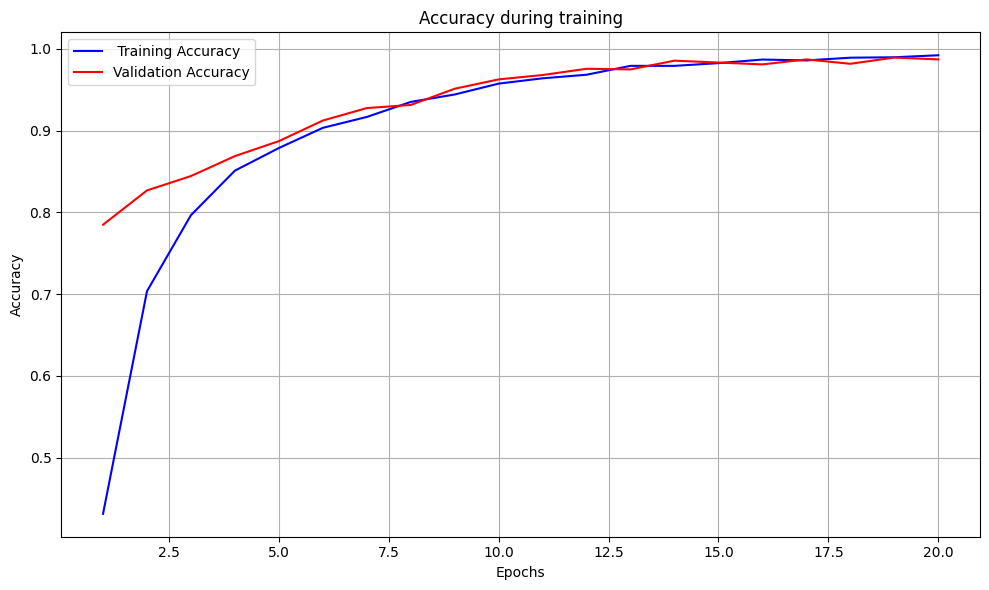

In [ ]:
import matplotlib.pyplot as plt

# Obtener métricas del historial
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'b-', label=' Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Nombres de las clases: ['glioma', 'meningioma', 'notumor', 'pituitary']

Evaluación detallada en el conjunto de test:
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - accuracy: 0.9829 - loss: 0.0417

Exactitud (Accuracy) en test: 0.9893
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - accuracy: 0.9829 - loss: 0.0417
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 313ms/step
Tamaño de y_true: 1311
Tamaño de y_pred_classes: 1311
Confusion matrix without normalization


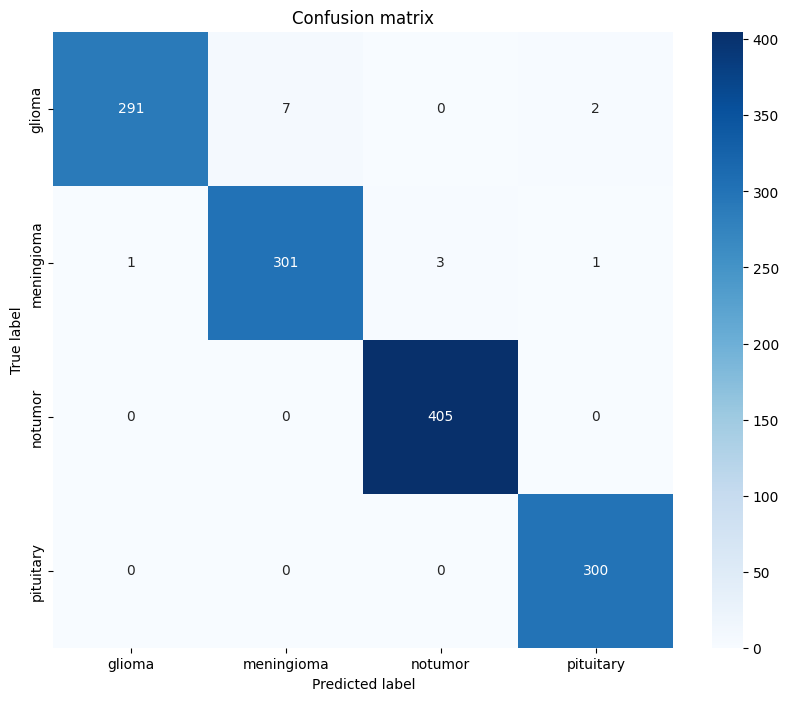


Reporte de Clasificación:
              precision    recall  f1-score   support

      glioma       1.00      0.97      0.98       300
  meningioma       0.98      0.98      0.98       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.99      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Primero obtenemos los nombres de las clases del generador de test
class_names = list(test_generator.class_indices.keys())
print("Nombres de las clases:", class_names)

# 2. Evaluar el modelo en el conjunto de test
print("\nEvaluación detallada en el conjunto de test:")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nExactitud (Accuracy) en test: {test_accuracy:.4f}")

# 3. Predecir las clases para el conjunto de test
test_generator.reset()
test_loss, test_accuracy = model.evaluate(test_generator)

test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print(f"Tamaño de y_true: {len(y_true)}")
print(f"Tamaño de y_pred_classes: {len(y_pred_classes)}")

# 4. Función para graficar matriz de confusión
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix without normalization')

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 5. Graficar matriz de confusión
plot_confusion_matrix(y_true, y_pred_classes, class_names, normalize=False)

# 6. Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))
